In [1]:
from pyspark.sql import SparkSession
from helper import read_sql_file, plot_multiple_line_graphs

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
spark = SparkSession.builder.appName("BDCCLab").master("local[*]").getOrCreate()

In [4]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
# spark.conf.set("spark.sql.parquet.enableVectorizedReader", "true")

In [5]:
# !ls /mnt/data/public/aws-public-blockchain/v1.0/eth/transactions/

In [6]:
df_eth_trans = spark.read.parquet("/mnt/data/public/aws-public-blockchain/v1.0/eth/transactions/")

In [7]:
spark.conf

In [8]:
# df_eth_trans.printSchema()

In [9]:
# df_eth_trans.select('transaction_type').distinct().show()

In [10]:
df_eth_trans.createOrReplaceTempView("df_eth_trans")

In [13]:
eth_tot_trans = spark.sql(read_sql_file("sql/eth_tot_value.sql")).toPandas()
eth_tot_trans

,year,value_in_wei,gas_in_wei,total_transactions
0,2015,9.184474e+25,168848725819,1046284
1,2016,6.625570e+26,1658547267429,13661080
2,2017,4.353256e+27,14233506195190,102941034
3,2018,1.142012e+27,43508135175253,251166529
4,2019,7.653053e+26,48104419415368,242832115
5,2020,9.428725e+26,66766375651570,344766970
6,2021,9.920981e+26,76748371084243,461807363
7,2022,6.946280e+26,72540975780480,408543268
8,2023,4.534225e+26,105323620360993,383100651
9,2024,1.851720e+26,37092140209459,155249958


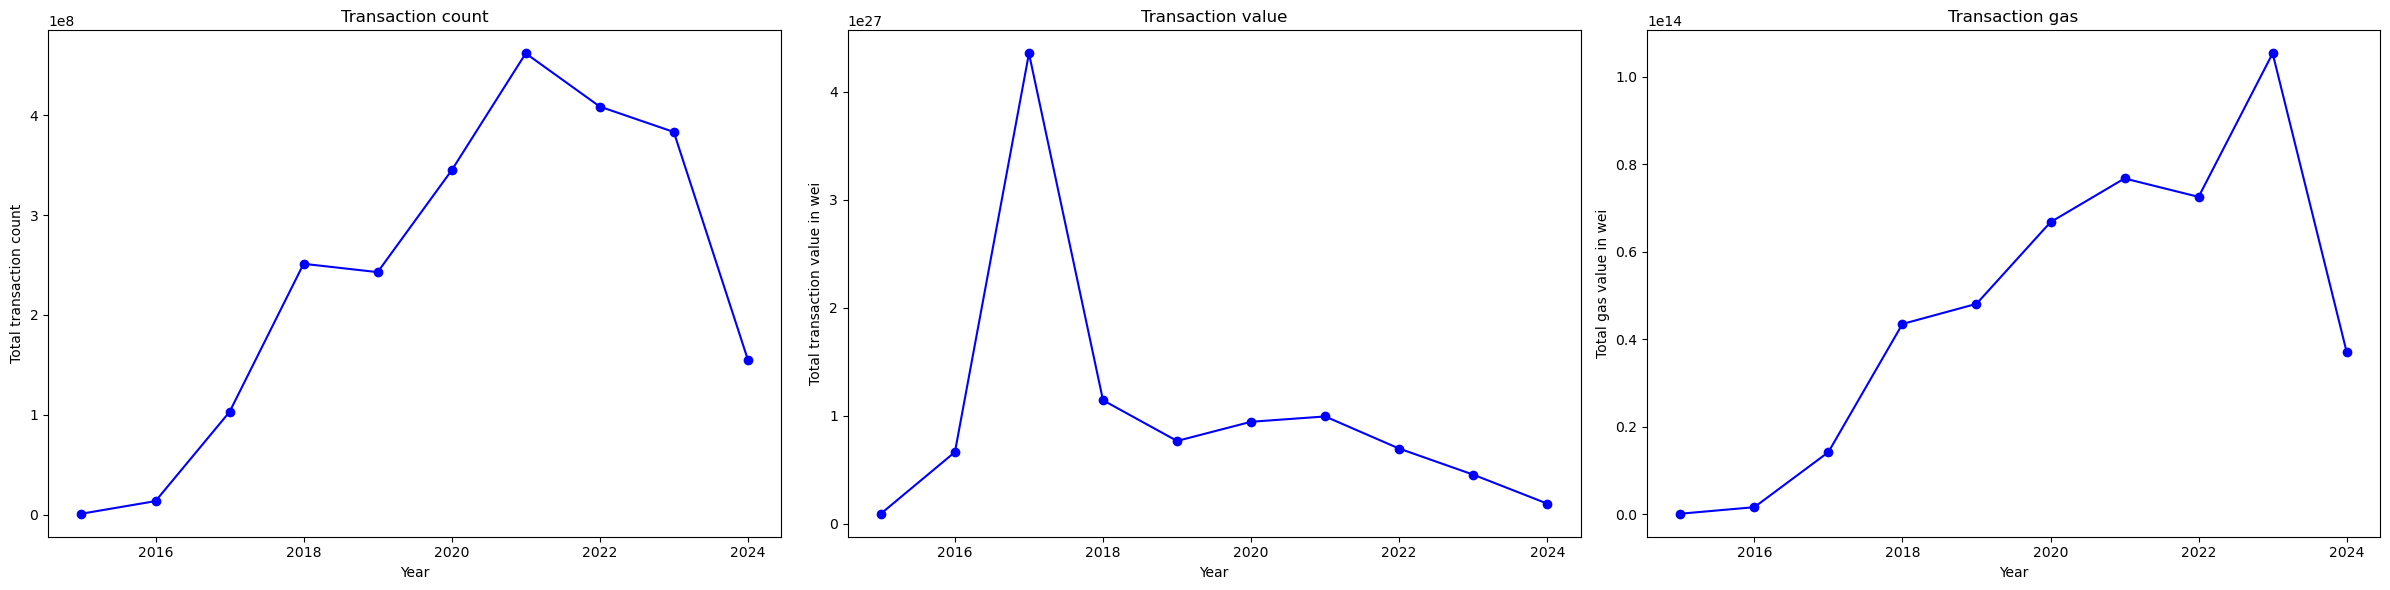

In [14]:
plot_multiple_line_graphs(
    x_list=[eth_tot_trans["year"], eth_tot_trans["year"], eth_tot_trans["year"]],
    y_list=[eth_tot_trans["total_transactions"], eth_tot_trans["value_in_wei"], eth_tot_trans["gas_in_wei"]],
    x_labels=["Year", "Year", "Year",],
    y_labels=["Total transaction count", "Total transaction value in wei",  "Total gas value in wei"],
    titles=["Transaction count", "Transaction value", "Transaction gas"],
    use_k=False,
    show_grid=False,
)